In [28]:
from enum import Enum
import time

import numpy as np
import pandas as pd

import matplotlib as plt

from google.cloud import translate_v2 as translate
from google.cloud.exceptions import Forbidden

from tqdm.auto import tqdm
tqdm.pandas() #allows progress bar support for pandas mapping functions

%matplotlib inline

%env GOOGLE_APPLICATION_CREDENTIALS translationKeys.json

env: GOOGLE_APPLICATION_CREDENTIALS=translationKeys.json


In [2]:
#The dataset provided consists of three csv files, each with slightly different schema
DATASET_1 = "dataset/7282_1.csv"
DATASET_2 = "dataset/Datafiniti_Hotel_Reviews.csv"
DATASET_3 = "dataset/Datafiniti_Hotel_Reviews_Jun19.csv"

DATASETS_IN_USE = [DATASET_1, DATASET_2, DATASET_3]

MIN_REVIEW_LENGTH = 0

TRAIN_PROPORTION = 0.1

USE_TRANSLATOR = True

TRANSLATOR_OPTIONS = Enum("OPTIONS", "TRANSLATE REMOVE THRESHOLD")
TRANSLATOR_FUNCTIONALITY = TRANSLATOR_OPTIONS.TRANSLATE #options are "translate", which translates non-english text to english, and 
                                        # "remove", which drops records with non-english text from the training set
TRANSLATOR_THRESHOLD=0.05

## 1. Pre-Preparation and Exploratory Analysis

### Dataset 1

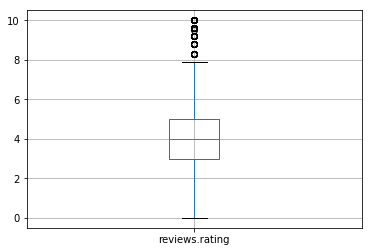

In [3]:
df_1 = pd.read_csv(DATASET_1)

#print(df)
#df_1.head()

df_1.boxplot(column="reviews.rating")


In [4]:
print(df_1["reviews.rating"].value_counts())

5.0     12671
4.0      9755
3.0      5708
1.0      3068
2.0      2979
0.0       337
10.0      101
9.6        53
9.2        49
4.3        26
4.8        25
8.3        25
7.9        24
7.5        24
8.8        24
4.2        22
3.4        17
4.1        14
6.3        14
7.1        13
4.5        13
6.7        12
5.4         9
4.6         7
3.1         7
5.8         6
4.4         6
3.3         6
4.7         6
4.9         6
2.4         4
2.5         3
3.8         3
3.7         2
3.2         2
3.9         2
2.8         1
1.3         1
9.5         1
1.5         1
6.0         1
2.9         1
7.0         1
Name: reviews.rating, dtype: int64


In [5]:
print(df_1[df_1["reviews.rating"] > 5].head())


              address categories      city country  latitude  longitude  \
4448  Taragaon Boudha     Hotels  Alliance      US   27.7216  85.355959   
4449  Taragaon Boudha     Hotels  Alliance      US   27.7216  85.355959   
4450  Taragaon Boudha     Hotels  Alliance      US   27.7216  85.355959   
4451  Taragaon Boudha     Hotels  Alliance      US   27.7216  85.355959   
4452  Taragaon Boudha     Hotels  Alliance      US   27.7216  85.355959   

                         name postalCode province          reviews.date  \
4448  Hyatt Regency Kathmandu      44601       OH  2015-08-11T00:00:00Z   
4449  Hyatt Regency Kathmandu      44601       OH  2016-01-12T00:00:00Z   
4450  Hyatt Regency Kathmandu      44601       OH  2015-06-22T00:00:00Z   
4451  Hyatt Regency Kathmandu      44601       OH  2016-05-17T00:00:00Z   
4452  Hyatt Regency Kathmandu      44601       OH  2016-07-09T00:00:00Z   

         reviews.dateAdded  reviews.doRecommend  reviews.id  reviews.rating  \
4448  2016-11-11T23

In [6]:
print(df_1[df_1["reviews.rating"] == 0].head())

                                      address  \
57                      2113 Sapp Brothers Dr   
58                             2860 Grand Ave   
59  142 Park Place Us 181 Business At Park Pl   
79                      435 E Avenida Olancha   
97                              316 N Main St   

                                          categories          city country  \
57                             Lodging,Hotels,Motels      Percival      US   
58                                Hotels,Restaurants    Los Olivos      US   
59                                            Hotels        Kenedy      US   
79                                      Hotels,Hotel  Palm Springs      US   
97  Motels,Hotels,Restaurants,Bed & Breakfast & Inns       Neihart      US   

     latitude   longitude                     name postalCode province  \
57  40.689730  -95.788826  Americas Best Value Inn      51648       IA   
58  34.664684 -120.115036               Intermezzo      93441       CA   
59  28.793795 

From the unique values in DATASET_1, it seems that, while most of the reviews are rated on an integer scale between 1 and 5, at least some of the reviews are rated from 1.0-10.0. These reviews should be removed or re-scaled (I have chosen to remove them, as there are comparatively very few of them and there may be differences between what a user means by choosing two equivalent ratings on the two scales - ie. a 8/10 rating may have different connotations on average to a 4/5 rating.)

Note: It is impossible to tell which of the remaining reviews are actually rated out of 10 rather than 5 - however, assuming the distribution of ratings out of 10 is similar to the distribution for ratings out of 5, there should be very few of these and their effect on any statistical analysis should be minor.

Additionally, a quick glance at the 0 ratings suggests that these are not real reviews, but some artifact of the scraping process, and so should be removed as well.

In [7]:
df_1 = df_1[df_1["reviews.rating"].isin([1.0,2.0,3.0,4.0,5.0])]

print(df_1["reviews.rating"].value_counts())

5.0    12671
4.0     9755
3.0     5708
1.0     3068
2.0     2979
Name: reviews.rating, dtype: int64


### Dataset 2

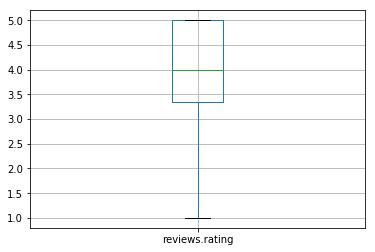

In [8]:
df_2 = pd.read_csv(DATASET_2)
df_2.head()

df_2.boxplot(column="reviews.rating")

In [9]:
print(df_2["reviews.rating"].value_counts())

5.00    4384
4.00    2397
3.00    1187
1.00     572
2.00     561
4.80     162
4.60     155
4.40     102
3.75      91
4.15      78
3.95      52
3.55      50
3.35      40
3.15      37
2.90      34
2.70      23
2.50      19
2.30      12
2.10      11
1.65       8
1.45       6
4.50       4
1.90       4
3.25       2
3.50       2
1.25       2
4.25       2
2.75       1
4.75       1
3.45       1
Name: reviews.rating, dtype: int64


### Dataset 3

5    4840
4    2849
3    1190
1     567
2     554
Name: reviews.rating, dtype: int64


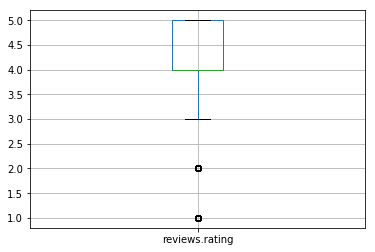

In [10]:
df_3 = pd.read_csv(DATASET_3)
df_3.head()

df_3.boxplot(column="reviews.rating")
print(df_3["reviews.rating"].value_counts())

In [11]:
#Find the columns that are present in each of the three datasets, and make sure that there aren't any important columns
# (review text, title, rating, etc.) that are functionally identical, but named differently
columns_intersection = set.intersection(set(df_1.columns.values),set(df_2.columns.values), set(df_3.columns.values))
print(columns_intersection)

{'reviews.rating', 'reviews.title', 'reviews.username', 'longitude', 'reviews.text', 'postalCode', 'latitude', 'reviews.userProvince', 'categories', 'province', 'reviews.date', 'name', 'reviews.userCity', 'city', 'country', 'address'}


In [12]:
#now concatenate the three data sources on the schema intersection

df = pd.concat([df_1, df_2, df_3], join="inner")

print(df.head())

                  address categories      city country   latitude  longitude  \
0  Riviera San Nicol 11/a     Hotels  Mableton      US  45.421611  12.376187   
1  Riviera San Nicol 11/a     Hotels  Mableton      US  45.421611  12.376187   
2  Riviera San Nicol 11/a     Hotels  Mableton      US  45.421611  12.376187   
3  Riviera San Nicol 11/a     Hotels  Mableton      US  45.421611  12.376187   
4  Riviera San Nicol 11/a     Hotels  Mableton      US  45.421611  12.376187   

                 name postalCode province          reviews.date  \
0  Hotel Russo Palace      30126       GA  2013-09-22T00:00:00Z   
1  Hotel Russo Palace      30126       GA  2015-04-03T00:00:00Z   
2  Hotel Russo Palace      30126       GA  2014-05-13T00:00:00Z   
3  Hotel Russo Palace      30126       GA  2013-10-27T00:00:00Z   
4  Hotel Russo Palace      30126       GA  2015-03-05T00:00:00Z   

   reviews.rating                                       reviews.text  \
0             4.0  Pleasant 10 min walk alon

In [13]:
df.count()

address                 54181
categories              54181
city                    54181
country                 54181
latitude                54115
longitude               54115
name                    54181
postalCode              54126
province                54181
reviews.date            54137
reviews.rating          54181
reviews.text            54158
reviews.title           53598
reviews.userCity        29876
reviews.username        54155
reviews.userProvince    29688
dtype: int64

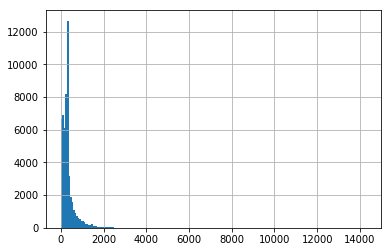

In [14]:
#df["reviews.text"].str.len().sum()

df["reviews.text"].str.len().hist(bins=200)



In [15]:
df = df.reset_index(drop=True)

## 2. Translation of non-English reviews 

In [34]:
client = translate.Client()

#uses the google cloud translate API to detect the text language, returning the language and the confidence
def detect_language(text):

    #get the translation from the API (allowing for a few seconds to breathe when at the rate limit)
    while(True):
        try:
            detection = client.detect_language(text)
        except Forbidden as e:
            print(e.message)
            
            #if we're brushing 
            if e.message == "POST https://translation.googleapis.com/language/translate/v2/detect: User Rate Limit Exceeded":
                time.sleep(1)
                continue
        break
        
    language = detection["language"]
    
    #because the API says that the confidence value is not always available, give a confidence value of 1 
    # (full confidence) if the confidence is not returned
    
    confidence = detection["confidence"] if "confidence" in detection else 1
    
    return language, confidence
    
#uses the google cloud translate API to
print(detect_language("aaaaaaa"))

def translate_text(text, source_lang="en", target_lang="en"):
    
    translation = client.translate(text, source_language=source_lang, target_language=target_lang)
    
    return translation["translatedText"]
    
print(translate_text("aaaaaaa", source_lang="vi"))

('vi', 0.8515625)
aaaaaaa


In [35]:
print(df.loc[360, :]["reviews.text"])

bernachtung fr einen Tag. Kostenloses Zimmer Upgrade von Standard Doppelzimmer auf Junior Suite . Sehr netter Empfang an der Rezeption . Sehr gute Zimmerausstattung mit riesiger Terrasse . Direkte Lage am Strand . Zahlreiche Restaurants im Hotel. Schne liebevoll eingerichtete Bar im Erdgeschoss . Ein tolles Hotel .


In [36]:
def translate_dataframe(frame):
    
    frame["detected_language"] = frame["reviews.text"].progress_map(detect_language)
    
    return frame

test_df = df.head().copy()
df_detected = translate_dataframe(test_df)
df_detected["detected_language"].head()



df = translate_dataframe(df)

POST https://translation.googleapis.com/language/translate/v2/detect: User Rate Limit Exceeded
POST https://translation.googleapis.com/language/translate/v2/detect: User Rate Limit Exceeded
POST https://translation.googleapis.com/language/translate/v2/detect: User Rate Limit Exceeded
POST https://translation.googleapis.com/language/translate/v2/detect: User Rate Limit Exceeded
POST https://translation.googleapis.com/language/translate/v2/detect: User Rate Limit Exceeded
POST https://translation.googleapis.com/language/translate/v2/detect: User Rate Limit Exceeded
POST https://translation.googleapis.com/language/translate/v2/detect: User Rate Limit Exceeded
POST https://translation.googleapis.com/language/translate/v2/detect: User Rate Limit Exceeded


KeyboardInterrupt: 